In [ ]:
!pip install tensorflow==2.7.1 tensorflow-gpu==2.7.1 tensorflow-io==0.23.1 matplotlib

In [4]:
import os
import csv
from matplotlib import pyplot as plt
import tensorflow as ft 
import tensorflow_io as iotf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from itertools import groupby

**Change the path as per your folder structure in drive to run the code successfully**

In [2]:
positive_label_path = '/content/drive/MyDrive/Data/SpeechRecognition/Parsed_Capuchinbird_Clips'
negative_label_path = '/content/drive/MyDrive/Data/SpeechRecognition/Parsed_Not_Capuchinbird_Clips'
test_file = '/content/drive/MyDrive/Data/SpeechRecognition/Forest Recordings'

In [ ]:
sample1 = os.path.join(positive_label_path, 'XC114131-0.wav')
sample2 = os.path.join(negative_label_path, 'Crickets-chirping-1.wav')

In [6]:
x = -1
y = ft.int64
z = 16000

In [7]:
def wave_processing(filepath):
  content = ft.io.read_file(filepath)
  wave, sr = ft.audio.decode_wav(content, desired_channels=1)
  wave = ft.squeeze(wave, axis=-1)
  sr = ft.cast(sr, dtype=ft.int64)
  wave = iotf.audio.resample(wave, rate_in=sr, rate_out=16000)
  return wave

In [8]:
sample1 = wave_processing(sample1)
sample2 = wave_processing(sample2)

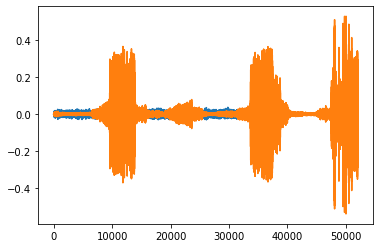

In [9]:
plt.figure(1)
plt.plot(sample1)
plt.plot(sample2)
plt.show()

In [10]:
positive_dataset = ft.data.Dataset.list_files(positive_label_path+'/*.wav')
negative_dataset = ft.data.Dataset.list_files(negative_label_path+'/*.wav')

In [11]:
positives_label = ft.data.Dataset.zip((positive_dataset, ft.data.Dataset.from_tensor_slices(ft.ones(len(positive_dataset)))))
negatives_label = ft.data.Dataset.zip((negative_dataset, ft.data.Dataset.from_tensor_slices(ft.zeros(len(negative_dataset)))))
dataset = positives_label.concatenate(negatives_label)

In [12]:
lengths = []
for file in os.listdir(positive_label_path):
    tensor_wave = wave_processing(os.path.join(positive_label_path, file))
    lengths.append(len(tensor_wave))

In [13]:
ft.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [14]:
ft.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [15]:
ft.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [16]:
def wave_to_spectro(path, label):
  waveform = wave_processing(path)
  waveform = waveform[:48000]
  padding_with_zero = ft.zeros([48000] - ft.shape(waveform), dtype=ft.float32)
  waveform = ft.concat([padding_with_zero, waveform], 0)
  spectro = ft.signal.stft(waveform, frame_length=320, frame_step=32)
  spectro = ft.abs(spectro)
  spectro = ft.expand_dims(spectro, axis=2)
  return spectro, label

In [17]:
f, l = positives_label.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [18]:
spectro, l = wave_to_spectro(f, l)

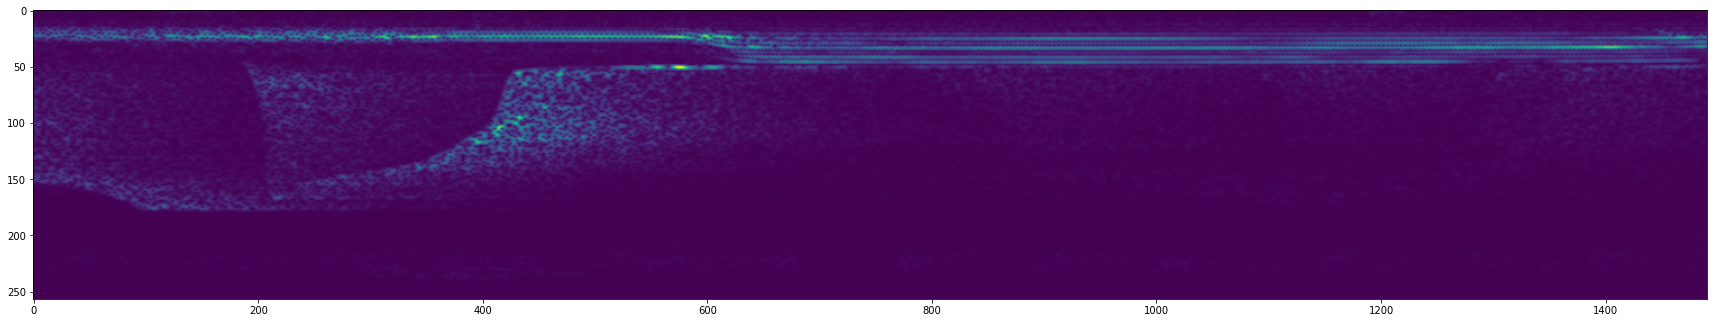

In [19]:
plt.figure(figsize=(30,20))
plt.imshow(ft.transpose(spectro)[0])
plt.show()

In [20]:
dataset = dataset.map(wave_to_spectro)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [21]:
train_data_size = round(len(dataset) * 0.7)

In [22]:
test_data_size = len(dataset) - train_data_size

In [23]:
training_data = dataset.take(train_data_size)
testing_data = dataset.skip(train_data_size).take(test_data_size)

In [24]:
record, label = training_data.as_numpy_iterator().next()

In [25]:
record.shape

(16, 1491, 257, 1)

In [26]:
mod_seq = Sequential()
mod_seq.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
mod_seq.add(MaxPooling2D(pool_size=(2, 2)))
mod_seq.add(Conv2D(16, (3,3), activation='relu'))
mod_seq.add(MaxPooling2D(pool_size=(2, 2)))
mod_seq.add(Flatten())
# mod_seq.add(Dense(128, activation='relu'))
mod_seq.add(Dense(1, activation='sigmoid'))

In [27]:
mod_seq.compile('Adam', loss='BinaryCrossentropy', metrics=[ft.keras.metrics.Recall(),ft.keras.metrics.Precision()])

In [28]:
mod_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 16)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 368032)            0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [29]:
hi = mod_seq.fit(training_data, epochs=4, validation_data=testing_data)

Epoch 1/4
36/36 [==============================] - 13s 92ms/step - loss: 0.2831 - recall: 0.9048 - precision: 0.8889 - val_loss: 0.0504 - val_recall: 0.9286 - val_precision: 0.9811
Epoch 2/4
36/36 [==============================] - 3s 77ms/step - loss: 0.0418 - recall: 0.9474 - precision: 0.9931 - val_loss: 0.0177 - val_recall: 1.0000 - val_precision: 0.9859
Epoch 3/4
36/36 [==============================] - 3s 79ms/step - loss: 0.0158 - recall: 0.9933 - precision: 0.9933 - val_loss: 0.0036 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 3s 79ms/step - loss: 0.0084 - recall: 0.9933 - precision: 1.0000 - val_loss: 0.0077 - val_recall: 1.0000 - val_precision: 1.0000


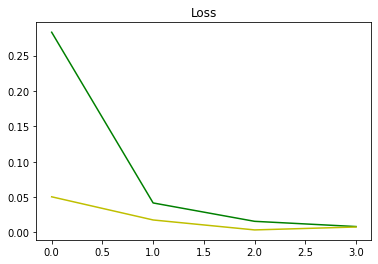

In [30]:
plt.title('Loss')
plt.plot(hi.history['loss'], 'g')
plt.plot(hi.history['val_loss'], 'y')
plt.show()

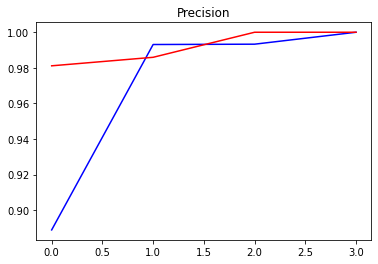

In [31]:
plt.title('Precision')
plt.plot(hi.history['precision'], 'b')
plt.plot(hi.history['val_precision'], 'r')
plt.show()

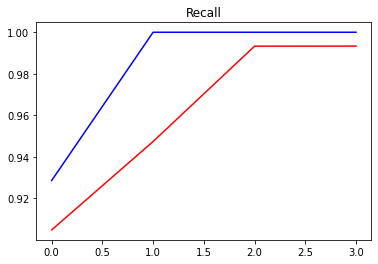

In [32]:
plt.title('Recall')
plt.plot(hi.history['recall'], 'r')
plt.plot(hi.history['val_recall'], 'b')
plt.show()

In [33]:
u_test, v_test = testing_data.as_numpy_iterator().next()

In [34]:
yhat = mod_seq.predict(u_test)

In [35]:
yhat = [1 if pred > 0.5 else 0 for pred in yhat]

In [36]:
a = 2
b = 1
file1 = "recording_15.mp3"
ro = 16000

In [37]:
def wave_processing_mp3(filename):
    response = iotf.audio.AudioIOTensor(filename)
    tss = response.to_tensor()
    tss = ft.math.reduce_sum(tss, axis=1) / 2 
    srate = response.rate
    srate = ft.cast(srate, dtype=ft.int64)
    wave = iotf.audio.resample(tss, rate_in=srate, rate_out=16000)
    return wave

In [38]:
test_record = os.path.join(test_file, 'recording_15.mp3')

In [39]:
wave = wave_processing_mp3(test_record)

In [40]:
wave_split = ft.keras.utils.timeseries_dataset_from_array(wave, wave, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [41]:
samples, index = wave_split.as_numpy_iterator().next()

In [42]:
def spectro_from_mp3(element, index):
    element = element[0]
    padding = ft.zeros([48000] - ft.shape(element), dtype=ft.float32)
    waveform = ft.concat([padding, element],0)
    spectro = ft.signal.stft(waveform, frame_length=320, frame_step=32)
    spectro = ft.abs(spectro)
    spectro = ft.expand_dims(spectro, axis=2)
    return spectro

In [43]:
yhat = [key for key, group in groupby(yhat)]
calls = ft.math.reduce_sum(yhat).numpy()

In [44]:
calls

3

In [45]:
results = {}
for ele in os.listdir(test_file):
    path = os.path.join(test_file, ele)
    
    waveform = wave_processing_mp3(path)
    audio = ft.keras.utils.timeseries_dataset_from_array(waveform, waveform, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio = audio.map(spectro_from_mp3)
    audio = audio.batch(64)
    
    yhat = mod_seq.predict(audio)
    
    results[ele] = yhat

In [46]:
result = {}
for x, y in results.items():
    result[x] = [1 if ele > 0.99 else 0 for ele in y]
result

{'recording_00.mp3': [0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [47]:
processed = {}
for x, y in result.items():
    processed[x] = ft.math.reduce_sum([key for key, group in groupby(y)]).numpy()
processed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 24,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 4,
 'recording_12.mp3': 2,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 6,
 'recording_17.mp3': 5,
 'recording_19.mp3': 0,
 'recording_18.mp3': 4,
 'recording_20 (1).mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 6,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_25.mp3': 5,
 'recording_24.mp3': 0,
 'recording_28.mp3': 6,
 'recording_29.mp3': 0,
 'recording_31.mp3': 1,
 'recording_30.mp3': 3,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_35.mp3': 0,
 'recording_34.mp3': 4,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 3,
 'recording_40.mp3': 1,
 'recording

In [48]:
with open('output.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_bird_calls'])
    for key, value in processed.items():
        writer.writerow([key, value])